In [1]:
## Tools

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query Arxiv for research papers.")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Explain the paper 'Attention is all you need' in detail")

'Published: 2018-07-02\nTitle: The Matrix Calculus You Need For Deep Learning\nAuthors: Terence Parr, Jeremy Howard\nSummary: This paper is an attempt to explain all the matrix calculus you need in order\nto understand the training of deep neural networks. We assume no math knowledge\nbeyond what you learned in calculus 1, and provide links to help you refresh\nthe necessary math where needed. Note that you do not need to understand this\nmaterial before you start learning to train and use deep learning'

In [6]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
wiki.invoke("Explain the paper 'Attention is all you need' in detail")

'Page: Transformer (deep learning architecture)\nSummary: The transformer is a deep learning architecture that was developed by researchers at Google and is based on the multi-head attention mechanism, which was proposed in the 2017 paper "Attention Is All You Need". Text is converted to numerical representations called tokens, and each token is converted into a vector via lookup from a word embedding table. At each layer, each token is then contextualized within the scope of the context window wi'

In [8]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [26]:
tavily.invoke("what happened in palgham in kashmir recently")

[{'title': 'Pahalgam wraps Kashmir in pall of gloom - Frontline - The Hindu',
  'url': 'https://frontline.thehindu.com/the-nation/pahalgam-terror-attack-kashmir-tourism-crisis-baisaran-massacre-security-lapse/article69486148.ece',
  'content': '“Kashmiris do not condone attacks on tourists, pilgrims, and civilians. What happened in Pahalgam is a massacre. Such acts also adversely impact the region’s economy,” said Bhasin, who is currently based in the US. [...] Similarly, People’s Conference leader Sajad Lone said in a conversation with Frontline that what happened in Pahalgam was an assault on the region’s centuries-old culture of hospitality. [...] Chairs and tables are scattered at the site of a terror attack on tourists in Baisaran Valley near Pahalgam in south Kashmir’s Anantnag district on April 24, 2025.\n                                          | Photo Credit: ADNAN ABIDI/REUTERS',
  'score': 0.81489426},
 {'title': 'Pahalgam attack: Militants kill at least 26 tourists in Kash

In [11]:
## Combine all the tools in the list
tools = [arxiv, wiki, tavily]

In [21]:
from langchain_groq import ChatGroq

llm=ChatGroq(model = "qwen-qwq-32b")
llm.invoke("what is agentic AI")

AIMessage(content='\n<think>\nOkay, so I need to figure out what "agentic AI" means. I remember hearing the term "agent" in AI before, like in agent-based models or something. Maybe "agentic" is related to that? Let me start by breaking down the term. "Agentic" probably comes from "agent," so maybe it\'s about AI that acts as an agent. But what exactly does that mean?\n\nI think agents in AI are systems that can perceive their environment and take actions to achieve goals. So an agentic AI would be an AI that can act independently, right? But I should check the key characteristics. Let me see. Maybe they have autonomy, meaning they can make decisions on their own without human intervention. Then there\'s goal-directed behavior, so they have objectives they\'re trying to achieve. Perception is important too—how they sense the environment. Adaptability would mean they can adjust to changes, and maybe social abilities to interact with other agents or humans.\n\nWait, the user mentioned th

In [22]:
llm_with_tools = llm.bind_tools(tools=tools)

In [25]:
# Execute the call
llm_with_tools.invoke("What happened in palgham Kashmir recently")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qa09', 'function': {'arguments': '{"query": "Recent events in Palgham Kashmir"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 294, 'prompt_tokens': 358, 'total_tokens': 652, 'completion_time': 0.733961193, 'prompt_time': 0.178508512, 'queue_time': 2.608557213, 'total_time': 0.912469705}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a043e222-6754-4ba5-8a15-1c7a274469de-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent events in Palgham Kashmir'}, 'id': 'call_qa09', 'type': 'tool_call'}], usage_metadata={'input_tokens': 358, 'output_tokens': 294, 'total_tokens': 652})

In [27]:
# Execute the call
llm_with_tools.invoke("What is machine learning")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f6bp', 'function': {'arguments': '{"query": "Machine learning"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 161, 'prompt_tokens': 354, 'total_tokens': 515, 'completion_time': 0.402639237, 'prompt_time': 0.06077999, 'queue_time': 4.309233003999999, 'total_time': 0.463419227}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_3796682456', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6719f023-aa67-46c4-a756-33be25c31008-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Machine learning'}, 'id': 'call_f6bp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 354, 'output_tokens': 161, 'total_tokens': 515})

## Workflow with Langgraph

In [32]:
## State Schema
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage ## Human message or AI message
from typing import Annotated # Labelling
from langgraph.graph.message import add_messages ## Reducers in Langgraph - This is used to append the messages to the graph

In [33]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
       

In [38]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


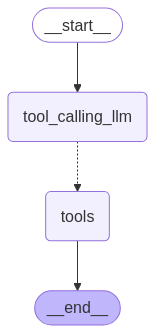

In [65]:
### Node definition

def tool_calling_llm(state:State):   
    return {"messages":[llm_with_tools.invoke(state["messages"])]} # Call the LLM with the tools and return the message"}

### Node definition

def tool_calling_llm(state:State):   
    return {"messages":[llm_with_tools.invoke(state["messages"])]} # Call the LLM with the tools and return the message"}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message (result) from assistant is a a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", END)

graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
messages = graph.invoke({"messages":"Attention is all you need"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_b9d5)
 Call ID: call_b9d5
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


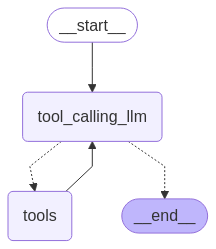

In [59]:
### Node definition

def tool_calling_llm(state:State):   
    return {"messages":[llm_with_tools.invoke(state["messages"])]} # Call the LLM with the tools and return the message"}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")

# Conditional routing: tool_calling_llm → tools or → end
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition  # This decides based on whether tools are needed
)

# After tools are used, go back to the tool_calling_llm for another round
builder.add_edge("tools", "tool_calling_llm")

# Add an end condition directly from tool_calling_llm (if no tools needed)
builder.add_edge("tool_calling_llm", END)


graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
messages = graph.invoke({"messages":"what is the recent AI News and tell me recent research paper on quantum computing"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent AI News and tell me recent research paper on quantum computing
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jhcp)
 Call ID: call_jhcp
  Args:
    query: recent AI news
  arxiv (call_vnbk)
 Call ID: call_vnbk
  Args:
    query: recent quantum computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Artificial Intelligence - Latest AI News and Analysis - WSJ.com", "url": "https://www.wsj.com/tech/ai", "content": "The latest artificial intelligence news coverage focusing on the technology, tools and the companies building AI technology.", "score": 0.71425}, {"title": "Artificial intelligence - NBC News", "url": "https://www.nbcnews.com/artificial-intelligence", "content": "Chinese A.I. app shakes up Silicon Valley, causing Wall S